### Naive/persistence model
Assumes each day's day prices predict the next in the same hour

In [60]:
import json
import csv
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import geopandas as gpd
import shapely
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon
from shapely.affinity import scale
import matplotlib.pyplot as plt
import glob
import os
import datetime
import pytz
from pytz import timezone

In [83]:
#Loading AS price data; downselecting to reg down prices
prices = pd.read_csv("../data/AS_price_vol.csv")
price = prices[['date','hr_beg','price_DAH_REGDN']]

In [84]:
price['dt'] = pd.to_datetime(price['date']+ " " + price['hr_beg'].astype(str)+ ":00")

#converting back to central time
utc = timezone('UTC')
tz = timezone('America/Chicago')
price['UTC'] = price['dt'].apply(lambda x: utc.localize(x))
price['Central'] = price['UTC'].apply(lambda x: x.astimezone(tz))
price['hr_beg'] = price['Central'].dt.hour
price['date'] = price['Central'].dt.date
price['year'] = price['Central'].dt.year

In [85]:
price.drop(columns=['dt','UTC','Central'], inplace=True)

In [86]:
#Lagging by 48!! hours
price_24 = price['price_DAH_REGDN'].shift(48)
df = pd.concat([price,price_24], axis=1)
df.columns = ['date','hr_beg','price','year','price_24']

In [87]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

In [88]:
#Downselecting to 2018
df_2018 = df[df['year']==2018]

In [89]:
#Calculating number of spikes captured in 2018
spike = np.percentile(df['price'][(df['year']<2018) & (df['year']>=2014)], 90)
df_2018['Actual spike'] = df_2018['price'] >= spike
df_2018['Predicted spike'] = df_2018['price_24'] >= spike
df_2018['Both spike'] = (df_2018['price'] >= spike) & (df_2018['price_24'] >= spike)
df_2018['Neither spike'] = (df_2018['price'] < spike) & (df_2018['price_24'] < spike)

In [90]:
spikes_correct = sum(df_2018['Both spike']) / sum(df_2018['Actual spike'])
overall_correct = (sum(df_2018['Both spike']) + sum(df_2018['Neither spike'])) / len(df_2018)
print("Spikes correctly predicted, 2018: " + str(spikes_correct))
print("Overall hours correctly predicted, 2018: " + str(overall_correct))

Spikes correctly predicted, 2018: 0.4585987261146497
Overall hours correctly predicted, 2018: 0.9420488250057039


In [91]:
#Calculating number of spikes captured, 2008-2017
df = df[(df['year']>=2014) & (df['year']<=2017)]
df['Actual spike'] = df['price'] >= spike
df['Predicted spike'] = df['price_24'] >= spike
df['Both spike'] = (df['price'] >= spike) & (df['price_24'] >= spike)
df['Neither spike'] = (df['price'] < spike) & (df['price_24'] < spike)

In [92]:
spikes_correct = sum(df['Both spike']) / sum(df['Actual spike'])
overall_correct = (sum(df['Both spike']) + sum(df['Neither spike'])) / len(df)
print("Spikes correctly predicted, 2014-2017: " + str(spikes_correct))
print("Overall hours correctly predicted, 2014-2017: " + str(overall_correct))

Spikes correctly predicted, 2014-2017: 0.4586894586894587
Overall hours correctly predicted, 2014-2017: 0.8916847144648353


# Outputting for optimization team

In [93]:
results = df_2018[['date','hr_beg','price','price_24']]

In [95]:
results.columns = ['date','hour','Actual_price','Predicted_price_48hr']

In [96]:
results.drop_duplicates(subset=['date','hour','Actual_price'], inplace=True)
results.reset_index(drop=True, inplace=True)

In [97]:
results.shape

(8760, 4)

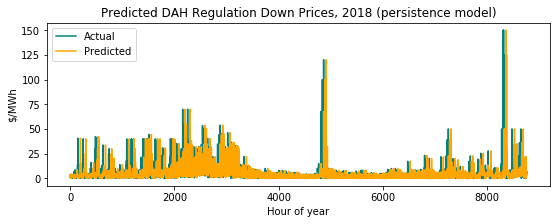

In [99]:
fig = plt.figure(figsize=(9,3))
plt.plot(results['Actual_price'], label="Actual", color='teal')
plt.plot(results['Predicted_price_48hr'], label="Predicted", color='orange')
plt.legend()
plt.title("Predicted DAH Regulation Down Prices, 2018 (persistence model)")
plt.xlabel('Hour of year')
plt.ylabel("$/MWh")
plt.savefig("persistence_results_48.png")

results.to_csv("persistence_results_48.csv", index=False)

# Autocorrelation

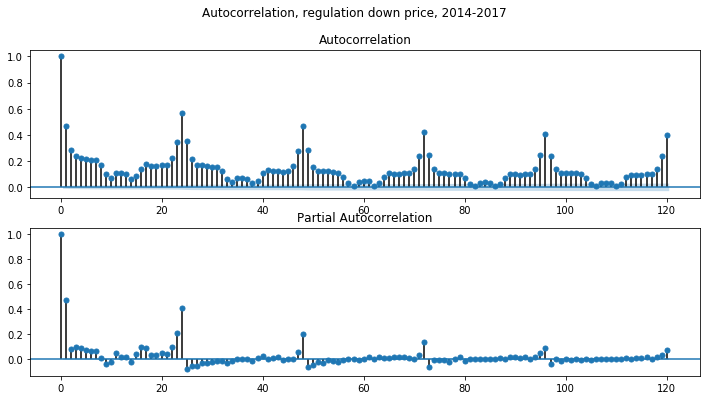

In [58]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df['price'].dropna(), ax=ax[0], lags=120)
ax[1] = plot_pacf(df['price'].dropna(), ax=ax[1], lags=120)
plt.suptitle("Autocorrelation, regulation down price, 2014-2017")
plt.savefig("autocorr.png")